# Training SimpleNN on CIFAR-10
In this project, you will use the SimpleNN model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only release the ground-truth labels of training/validation dataset to you.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 0: Set up the SimpleNN model
As you have practiced to implement simple neural networks in Homework 1, we just prepare the implementation for you.

In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
import numpy as np
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.utils import _single, _pair, _triple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# define the SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        # self.conv1 = CONV(3, 8, 5)
        # self.conv2 = CONV(8, 16, 3)
        # self.fc1   = FC(16*6*6, 120)
        # self.fc2   = FC(120, 84)
        # self.fc3   = FC(84, 10)

    def forward(self, x):
        def swish(pre):
          return pre * F.sigmoid(pre)

        # out = F.relu(self.bn1(self.conv1(x)))
        out = swish(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        # out = F.relu(self.bn2(self.conv2(out)))
        out = swish(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        # out = F.relu(self.fc1(out))
        out = swish(self.fc1(out))
        # out = F.relu(self.fc2(out))
        out = swish(self.fc2(out))
        # out = F.relu(self.fc3(out))
        out = swish(self.fc3(out))
        return out


In [ ]:
class CONV(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=False, padding_mode='zeros'):
        self.input = None
        self.output = None
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(CONV, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation, 
            groups, bias, padding_mode)
    
    def forward(self, input):
        self.input = input
        if '1.4' in torch.__version__:
            self.output = self.conv2d_forward(input, self.weight, self.bias) #1.4ｓ
        else:
            self.output = self._conv_forward(input, self.weight, self.bias) #1.5
        return self.output
    
class FC(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        self.input = None
        self.output = None
        super(FC, self).__init__(in_features, out_features, bias)
    
    def forward(self, input):
        self.input = input
        self.output = F.linear(input, self.weight, self.bias)
        return self.output

### Question (a)
Here is a sanity check to verify the implementation of SimpleNN. 
You need to:
1. Write down your code.
2. **In the PDF report**, give a brief description on how the code helps you know that SimpleNN is implemented correctly.

In [ ]:
#############################################
# your code here
# sanity check for the correctness of SimpleNN
# the cifar 10 image has the size of 32x32
size = 32
dummy = torch.randn(5, 3, size, size)
# dummy = np.zeros((size, size))
# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")
    
net = SimpleNN()
net = net.to(device)
out = net(dummy)
print(out.shape)

for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        input = module.input.detach().numpy()    
        output = module.output.detach().numpy()     
        weight = module.weight.detach().numpy()     
        if isinstance(module, CONV):
            num_Param = weight.size
        else:
            num_Param = module.bias.detach().numpy().size + output.shape[1] * input.shape[1]
        print(f'{name:10} {str(num_Param):10}')


#############################################

Run on CPU...
torch.Size([5, 10])
conv1      600       
conv2      1152      
fc1        69240     
fc2        10164     
fc3        850       


## Step 1: Set up preprocessing functions
Preprocessing is very important as discussed in the lecture.
You will need to write preprocessing functions with the help of *torchvision.transforms* in this step.
You can find helpful tutorial/API at [here](https://pytorch.org/vision/stable/transforms.html).

### Question (b)
For the question, you need to:
1. Complete the preprocessing code below.
2. **In the PDF report**, briefly describe what preprocessing operations you used and what are the purposes of them.

Hint: 
1. Only two operations are necessary to complete the basic preprocessing here.
2. The raw input read from the dataset will be PIL images.
3. Data augmentation operations are not mendatory, but feel free to incorporate them if you want.
4. Reference value for mean/std of CIFAR-10 images (assuming the pixel values are within [0,1]): mean (RGB-format): (0.4914, 0.4822, 0.4465), std (RGB-format): (0.2023, 0.1994, 0.2010)

In [3]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function
# transform_train = torch.nn.Sequential(
#     transforms.CenterCrop(10),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# )

transform_train = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                      transforms.RandomRotation(0.5), 
                                      transforms.RandomCrop(32, padding = 4),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# transform_val = torch.nn.Sequential(
#     transforms.CenterCrop(10),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# )

transform_val = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                      transforms.RandomRotation(0.5), 
                                      transforms.RandomCrop(32, padding = 4),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
#############################################

## Step 2: Set up dataset and dataloader

### Question (c)
Set up the train/val datasets and dataloders that are to be used during the training. Check out the [official API](https://pytorch.org/docs/stable/data.html) for more information about **torch.utils.data.DataLoader**.

Here, you need to:
1. Complete the code below.

In [4]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train    # your code
)
val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val    # your code
)

# construct dataloader
train_loader = DataLoader(
    train_set, 
    batch_size=TRAIN_BATCH_SIZE,  # your code
    shuffle=True,     # your code
    num_workers=4
)
val_loader = DataLoader(
    val_set, 
    batch_size=VAL_BATCH_SIZE,  # your code
    shuffle=False,     # your code
    num_workers=4
)
print(len(train_loader))
#############################################

0it [00:00, ?it/s]

Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
352


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
!rm -r data

## Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.
### Question (d)
You may want to deploy your model to GPU device for efficient training. Please assign your model to GPU if possible. If you are training on a machine without GPUs, please deploy your model to CPUs.

Here, you need to:
1. Complete the code below.
2. **In the PDF report**, briefly describe how you verify that your model is indeed deployed on GPU. (Hint: check $\texttt{nvidia-smi}$.)

In [5]:
# specify the device for computation
#############################################
# your code here           
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")
    
#############################################

Run on GPU...


In [7]:

model = SimpleNN()
model = model.to(device)


In [8]:
!nvidia-smi

Wed Sep 28 23:27:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W /  70W |    612MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum. 

### Question (e)
Here, you need to:
1. Set up the cross-entropy loss as the criterion. (Hint: there are implemented functions in **torch.nn**)
2. Specify a SGD optimizer with momentum. (Hint: there are implemented functions in **torch.optim**)

In [ ]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss().to(device)
# Add optimizer
optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
#############################################

## Step 5: Start the training process.

### Question (f)/(g)
Congratulations! You have completed all of the previous steps and it is time to train our neural network.

Here you need to:
1. Complete the training codes.
2. Actually perform the training.

Hint: Training a neural network usually repeats the following 4 steps: 

**i) Get a batch of data from the dataloader and copy it to your device (GPU).**

**ii) Do a forward pass to get the outputs from the neural network and compute the loss. Be careful about your inputs to the loss function. Are the inputs required to be the logits or softmax probabilities?)**

**iii) Do a backward pass (back-propagation) to compute gradients of all weights with respect to the loss.**

**iiii) Update the model weights with the optimizer.**

You will also need to compute the accuracy of training/validation samples to track your model's performance over each epoch (the accuracy should be increasing as you train for more and more epochs).


==> Training starts!
Epoch 0:


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


initial loss:  tensor(2.3096, device='cuda:0', grad_fn=<NllLossBackward0>)
total:  45000
correct:  11543
Training loss: 1.9794, Training accuracy: 0.2565
Validation loss: 1.6705, Validation accuracy: 0.3776

Epoch 1:
total:  45000
correct:  18633
Training loss: 1.5854, Training accuracy: 0.4141
Validation loss: 1.5437, Validation accuracy: 0.4414

Epoch 2:
total:  45000
correct:  20565
Training loss: 1.4888, Training accuracy: 0.4570
Validation loss: 1.5155, Validation accuracy: 0.4480

Epoch 3:
total:  45000
correct:  21781
Training loss: 1.4339, Training accuracy: 0.4840
Validation loss: 1.5370, Validation accuracy: 0.4458

Epoch 4:
total:  45000
correct:  22344
Training loss: 1.4019, Training accuracy: 0.4965
Validation loss: 1.4028, Validation accuracy: 0.4902

Epoch 5:
total:  45000
correct:  22857
Training loss: 1.3714, Training accuracy: 0.5079
Validation loss: 1.4354, Validation accuracy: 0.4920

Epoch 6:
total:  45000
correct:  22994
Training loss: 1.3605, Training accuracy: 0

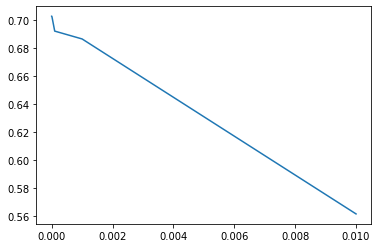

In [9]:
# some hyperparameters
# total number of training epochs
EPOCHS = 30

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
# best_val_acc = 0
# current_learning_rate = INITIAL_LR
# DECAY_EPOCHS = 10
# DECAY = 0.1
# a = 0
MOMENTUM = 0.9
REG = [1e-2, 1e-3, 1e-4, 1e-5, 0.0]

INITIAL_LR = 0.01
accuracy = []
print("==> Training starts!")
print("="*50)
for reg in REG:
  model = SimpleNN()
  model = model.to(device)
  criterion = nn.CrossEntropyLoss().to(device)
  optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=reg)
  best_val_acc = 0
  a = 0 

  for i in range(0, EPOCHS):
      # handle the learning rate scheduler.
      # if i % DECAY_EPOCHS == 0 and i != 0:
      #     current_learning_rate = current_learning_rate * DECAY
      #     for param_group in optimizer.param_groups:
      #         param_group['lr'] = current_learning_rate
      #     print("Current learning rate has decayed to %f" %current_learning_rate)
      
      #######################
      # your code here
      # switch to train mode
      model.train()
      
      #######################
      
      print("Epoch %d:" %i)
      # this help you compute the training accuracy
      total_examples = 0
      correct_examples = 0

      train_loss = 0 # track training loss if you want
      
      # Train the model for 1 epoch.
      for batch_idx, (inputs, targets) in enumerate(train_loader):
          ####################################
          # your code here
          # copy inputs to device
          inputs = inputs.type(torch.cuda.FloatTensor)
          output = model(inputs)
          output = output.to(device)
          
          # compute the output and loss
          loss = criterion(output, targets.to(device))
          if a == 0:
            print("initial loss: ", loss)
          a += 1
          train_loss += loss
          # zero the gradient
          optimizer.zero_grad()
          
          # backpropagation
          loss.backward()
          
          # apply gradient and update the weights
          optimizer.step()

          # count the number of correctly predicted samples in the current batch

          for i in range(len(output)):
            if torch.max(output,dim=1)[1][i] == targets[i]:
              correct_examples +=1
            total_examples += 1
          ####################################
      print("total: ", total_examples)   
      print("correct: ", correct_examples)       
      avg_loss = train_loss / len(train_loader)
      avg_acc = correct_examples / total_examples
      print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

      # Validate on the validation dataset
      #######################y
      # your code here
      # switch to eval mode
      model.eval()
      
      #######################

      # this help you compute the validation accuracy
      total_examples = 0
      correct_examples = 0
      
      val_loss = 0 # again, track the validation loss if you want

      # disable gradient during validation, which can save GPU memory
      with torch.no_grad():
          for batch_idx, (inputs, targets) in enumerate(val_loader):
              ####################################
              # your code here
              # copy inputs to device
              inputs = inputs.type(torch.cuda.FloatTensor)
              output = model(inputs)
              output = output.to(device)
              
              # compute the output and loss
              loss = criterion(output, targets.to(device))
              val_loss += loss
              # count the number of correctly predicted samples in the current batch
              for i in range(len(output)):
                if torch.max(output,dim=1)[1][i] == targets[i]:
                  correct_examples +=1
                total_examples += 1
              
              ####################################

      avg_loss = val_loss / len(val_loader)
      avg_acc = correct_examples / total_examples
      print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
      
      # save the model checkpoint
      if avg_acc > best_val_acc:
          best_val_acc = avg_acc
      #     if not os.path.exists(CHECKPOINT_FOLDER):
      #        os.makedirs(CHECKPOINT_FOLDER)
      #     print("Saving ...")
      #     state = {'state_dict': model.state_dict(),
      #             'epoch': i,
      #             'lr': current_learning_rate}
      #     torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))
          
      print('')
  accuracy.append(best_val_acc)
  print("="*50)
  print("current regularization strength rate is: ",  reg)
  print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")
print("Done with training all the learning rate")
plt.plot(REG, accuracy)

# Bonus: with learning rate decay

The following code can help you adjust the learning rate during training. You need to figure out how to incorporate this code into your training loop.
```python
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
```